In [1]:
import polars as pl

import rustystats as rs

import matplotlib.pyplot as plt
import numpy as np

data = pl.read_parquet("https://raw.githubusercontent.com/PricingFrontier/pricing-data-example/917c853e256df8d5814721ab56f72889a908bb08/data/processed/frequency_set.parquet")

In [2]:
exploration = rs.explore_data(
    data=data,
    response="ClaimCount",
    categorical_factors=["Region", "Area"],
    continuous_factors=["VehPower", "VehAge"],
    exposure="Exposure",
)

In [3]:
exploration.to_json()

'{"data_summary": {"n_rows": 678012, "n_columns": 13, "response_column": "ClaimCount", "exposure_column": "Exposure", "n_categorical_factors": 2, "n_continuous_factors": 2}, "factor_stats": [{"name": "VehPower", "type": "continuous", "mean": 6.454630596508617, "std": 2.050905590758379, "min": 4.0, "max": 15.0, "missing_count": 0, "missing_pct": 0.0, "response_by_bin": [{"bin_index": 1, "bin_lower": 4.0, "bin_upper": 5.0, "count": 115349, "exposure": 60073.637303557, "response_sum": 5605.0, "response_rate": 0.09330215801113352}, {"bin_index": 3, "bin_lower": 5.0, "bin_upper": 6.0, "count": 124821, "exposure": 68173.348820864, "response_sum": 7159.0, "response_rate": 0.10501171093723703}, {"bin_index": 5, "bin_lower": 6.0, "bin_upper": 7.0, "count": 148976, "exposure": 82524.210171993, "response_sum": 8260.0, "response_rate": 0.10009183950727797}, {"bin_index": 7, "bin_lower": 7.0, "bin_upper": 8.0, "count": 145400, "exposure": 77949.53670018699, "response_sum": 7503.0, "response_rate": 

In [ ]:
data = data.with_columns([
    pl.col("Density").log().alias("log_Density"),
    pl.col("BonusMalus").log().alias("log_BonusMalus"),
])

formula = """
    ClaimCount ~
    ns(VehPower, df=4) +
    ns(VehAge, df=4) +
    ns(DrivAge, df=6) +
    bs(BonusMalus, df=4) +
    TE(VehBrand) +
    TE(VehGas) +
    TE(Area) +
    bs(Density, df=4) +
    TE(Region)
"""

formula_smooth = """
    ClaimCount ~
    s(VehPower) +
    s(VehAge) +
    s(DrivAge) +
    s(BonusMalus) +
    TE(VehBrand) +
    TE(VehGas) +
    TE(Area) +
    s(Density) +
    TE(Region)
"""

model = rs.glm(
    formula=formula,
    data=data,
    family="poisson",
    offset="Exposure"
).fit(alpha=0.01, l1_ratio=0.5)

In [20]:
print(model.summary())

                                 GLM Results                                  

Family:              Poisson         No. Observations:        678012
Link Function:       (default)       Df Residuals:            677980
Method:              IRLS + Elasticnet Df Model:                    31
Scale:               1.0000          Alpha (λ):               0.0100
L1 Ratio:            0.50            Iterations:                  25
Non-zero coefs:      31             

Log-Likelihood:         -140190.0061 Deviance:                211379.8661
AIC:                     280444.0123 Null Deviance:           214041.4441
BIC:                     280809.6737 Pearson chi2:             1601991.32
Converged:           False          

------------------------------------------------------------------------------
Variable                 Coef    Std.Err        z    P>|z|                 95% CI     
------------------------------------------------------------------------------
Intercept             -3.7327 

In [21]:
# Predict on the data
predictions = model.predict(data, offset="Exposure")
print(f"Predictions shape: {predictions.shape}")
print(f"Mean predicted claim rate: {predictions.mean():.6f}")
print(f"Min: {predictions.min():.6f}, Max: {predictions.max():.6f}")

plot_data = data.with_columns([
    pl.lit(predictions).alias("Predicted"),
    pl.col("ClaimCount").alias("Actual")
])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 32 is different from 5)

In [ ]:
def plot_ae_chart(
    data: pl.DataFrame,
    factor: str,
    bins: list = None,
    use_rate: bool = False,
    figsize: tuple = (12, 4),
    title: str = None,
):
    """
    Plot Actual vs Expected chart with exposure bars and A/E ratio.
    
    Parameters
    ----------
    data : pl.DataFrame
        Data with 'Actual', 'Predicted', and 'Exposure' columns.
    factor : str
        Column name to group by.
    bins : list, optional
        For continuous factors, bin edges. If None, treats factor as categorical.
    use_rate : bool
        If True, plot rates (per exposure) instead of counts.
    figsize : tuple
        Figure size.
    title : str, optional
        Custom title. Defaults to factor name.
    """
    # Bin continuous factors if bins provided
    if bins is not None:
        bin_col = f"{factor}_bin"
        grouped = data.with_columns([
            pl.col(factor).cut(bins).alias(bin_col)
        ]).group_by(bin_col).agg([
            pl.col("Actual").sum().alias("Actual"),
            pl.col("Predicted").sum().alias("Expected"),
            pl.col("Exposure").sum().alias("Exposure")
        ])
        
        # Create proper sort order based on bin edges (not alphabetical)
        bin_labels = grouped[bin_col].to_list()
        # Extract the lower bound from each bin label for sorting
        def get_bin_lower(label):
            if label is None:
                return float('inf')
            s = str(label)
            # Handle formats like "(0, 2]" or "(-inf, 0]"
            try:
                lower = s.split(',')[0].strip('([')
                if lower == '-inf':
                    return float('-inf')
                return float(lower)
            except:
                return float('inf')
        
        sort_order = sorted(range(len(bin_labels)), key=lambda i: get_bin_lower(bin_labels[i]))
        grouped = grouped[sort_order]
        labels = [str(b) for b in grouped[bin_col].to_list()]
    else:
        grouped = data.group_by(factor).agg([
            pl.col("Actual").sum().alias("Actual"),
            pl.col("Predicted").sum().alias("Expected"),
            pl.col("Exposure").sum().alias("Exposure")
        ]).sort(factor)
        labels = [str(v) for v in grouped[factor].to_list()]
    
    # Calculate A/E and rates
    grouped = grouped.with_columns([
        (pl.col("Actual") / pl.col("Expected")).alias("A/E"),
        (pl.col("Actual") / pl.col("Exposure")).alias("Actual_Rate"),
        (pl.col("Expected") / pl.col("Exposure")).alias("Expected_Rate")
    ])
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    x = np.arange(len(labels))
    
    # Left: Exposure bar with Actual/Expected lines
    ax1 = axes[0]
    ax2 = ax1.twinx()
    
    ax1.bar(x, grouped["Exposure"].to_numpy(), alpha=0.3, color="gray", label="Exposure")
    ax1.set_ylabel("Exposure", color="gray")
    ax1.tick_params(axis="y", labelcolor="gray")
    ax1.set_ylim(bottom=0)
    
    if use_rate:
        y_actual = grouped["Actual_Rate"].to_numpy()
        y_expected = grouped["Expected_Rate"].to_numpy()
        y_label = "Claim Rate"
    else:
        y_actual = grouped["Actual"].to_numpy()
        y_expected = grouped["Expected"].to_numpy()
        y_label = "Claim Count"
    
    ax2.plot(x, y_actual, "o-", color="steelblue", linewidth=2, markersize=8, label="Actual")
    ax2.plot(x, y_expected, "s--", color="coral", linewidth=2, markersize=8, label="Expected")
    ax2.set_ylabel(y_label, color="black")
    ax2.set_ylim(bottom=0)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45 if bins else 0, ha="right" if bins else "center")
    ax1.set_xlabel(title or factor)
    ax1.set_title(f"Actual vs Expected by {title or factor}")
    ax2.legend(loc="upper left")
    
    # Right: A/E ratio
    ae_vals = grouped["A/E"].to_numpy()
    colors = ["green" if 0.95 <= v <= 1.05 else "orange" if 0.9 <= v <= 1.1 else "teal" for v in ae_vals]
    axes[1].bar(labels, ae_vals, color=colors)
    axes[1].axhline(y=1.0, color="red", linestyle="--", label="Perfect calibration")
    axes[1].set_xticks(range(len(labels)))
    axes[1].set_xticklabels(labels, rotation=45 if bins else 0, ha="right" if bins else "center")
    axes[1].set_xlabel(title or factor)
    axes[1].set_ylabel("A/E Ratio")
    axes[1].set_title(f"A/E Ratio by {title or factor}")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return grouped

In [22]:
print(formula)


    ClaimCount ~
    ns(VehPower, df=4) +
    ns(VehAge, df=4) +
    ns(DrivAge, df=6) +
    bs(BonusMalus, df=4) +
    TE(VehBrand) +
    TE(VehGas) +
    TE(Area) +
    bs(Density, df=4) +
    TE(Region)



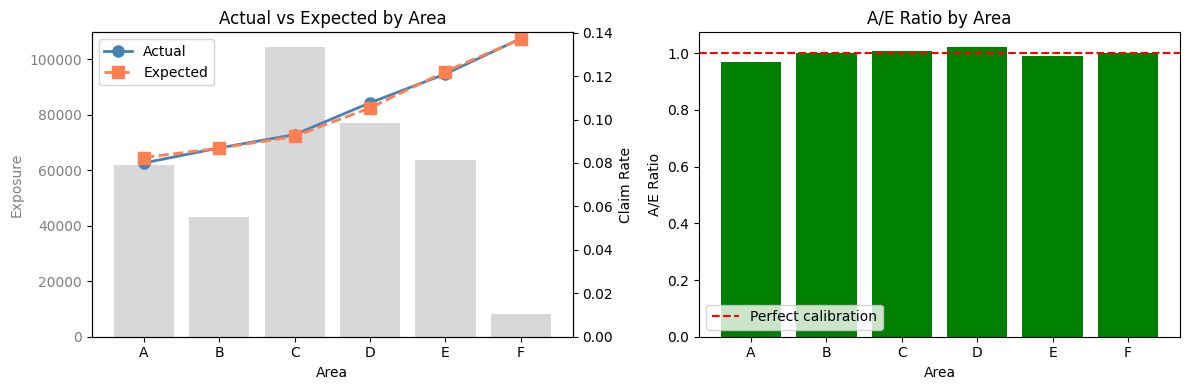

Area,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
str,i32,f64,f64,f64,f64,f64
"""A""",4958,5113.126861,61969.377712,0.969661,0.080007,0.082511
"""B""",3739,3733.83391,43012.323931,1.001384,0.086929,0.086808
"""C""",9719,9636.888476,104449.003785,1.008521,0.09305,0.092264
"""D""",8307,8126.160651,77119.271692,1.022254,0.107716,0.105371
"""E""",7721,7792.993994,63819.31427,0.990762,0.120982,0.12211
"""F""",1116,1114.115248,8129.234074,1.001692,0.137282,0.13705


In [23]:
plot_ae_chart(plot_data, "Area", use_rate=True)

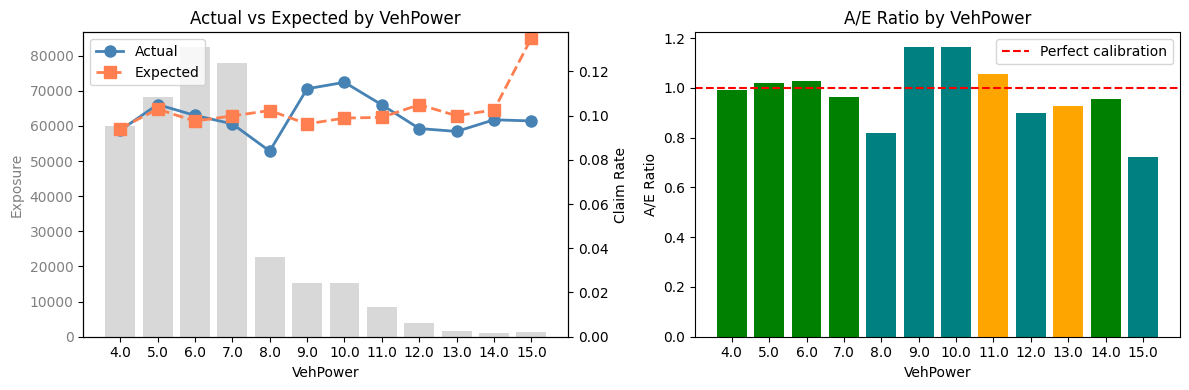

VehPower,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
f64,i32,f64,f64,f64,f64,f64
4.0,5605,5653.296459,60073.637304,0.991457,0.093302,0.094106
5.0,7159,7018.965285,68173.348821,1.019951,0.105012,0.102958
6.0,8260,8046.527708,82524.210172,1.02653,0.100092,0.097505
7.0,7503,7784.659437,77949.5367,0.963819,0.096255,0.099868
8.0,1904,2320.138675,22684.616305,0.820641,0.083934,0.102278
…,…,…,…,…,…,…
11.0,891,842.935737,8497.778452,1.05702,0.104851,0.099195
12.0,357,397.92522,3792.038343,0.897153,0.094145,0.104937
13.0,152,163.631662,1637.255322,0.928916,0.092838,0.099943


In [24]:
plot_ae_chart(plot_data, "VehPower", use_rate=True)

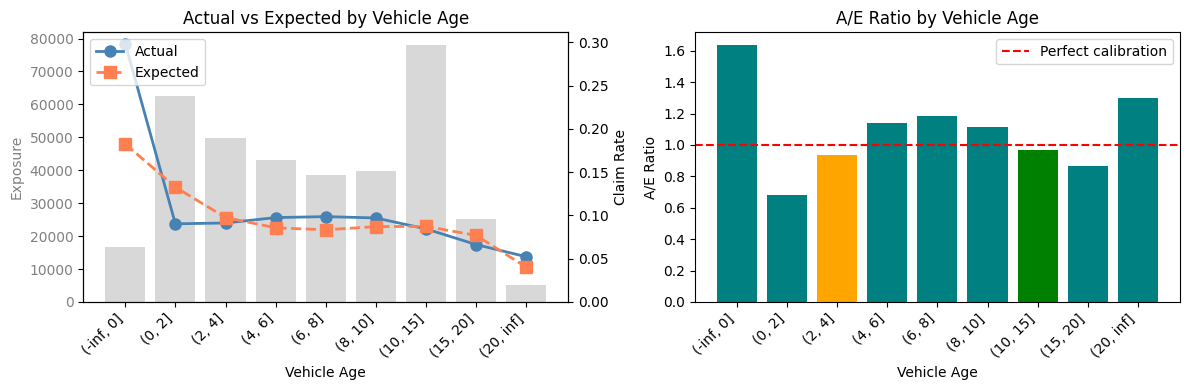

VehAge_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 0]""",4996,3054.611944,16719.028729,1.63556,0.298821,0.182703
"""(0, 2]""",5641,8287.648479,62457.026619,0.680651,0.090318,0.132694
"""(2, 4]""",4550,4864.787911,49841.358576,0.935293,0.09129,0.097605
"""(4, 6]""",4193,3684.153537,42987.678107,1.138118,0.09754,0.085703
"""(6, 8]""",3797,3210.781148,38486.488979,1.182578,0.098658,0.083426
"""(8, 10]""",3858,3460.343994,39732.594475,1.114918,0.097099,0.087091
"""(10, 15]""",6588,6814.705179,77990.975407,0.966733,0.084471,0.087378
"""(15, 20]""",1668,1933.149433,25136.158607,0.862841,0.066359,0.076907
"""(20, inf]""",269,206.937514,5147.215965,1.299909,0.052261,0.040204


In [25]:
plot_ae_chart(plot_data, "VehAge", bins=[0, 2, 4, 6, 8, 10, 15, 20], use_rate=True, title="Vehicle Age")

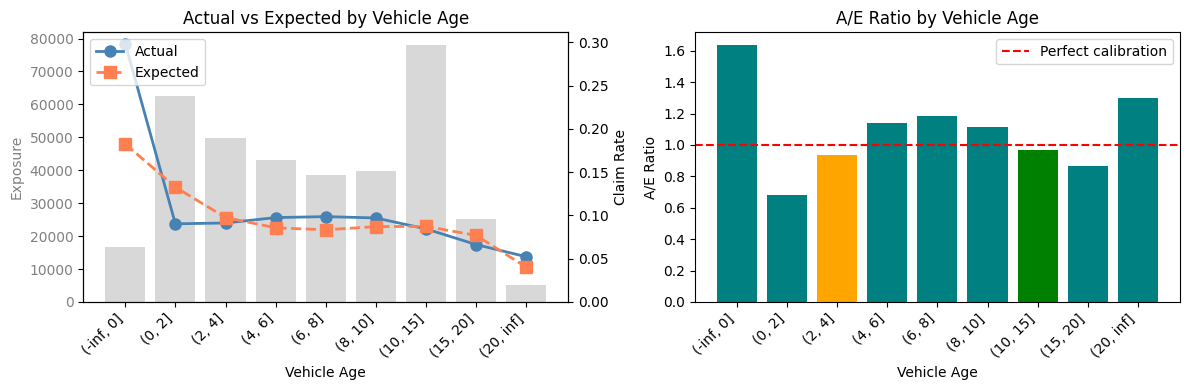

VehAge_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 0]""",4996,3054.611944,16719.028729,1.63556,0.298821,0.182703
"""(0, 2]""",5641,8287.648479,62457.026619,0.680651,0.090318,0.132694
"""(2, 4]""",4550,4864.787911,49841.358576,0.935293,0.09129,0.097605
"""(4, 6]""",4193,3684.153537,42987.678107,1.138118,0.09754,0.085703
"""(6, 8]""",3797,3210.781148,38486.488979,1.182578,0.098658,0.083426
"""(8, 10]""",3858,3460.343994,39732.594475,1.114918,0.097099,0.087091
"""(10, 15]""",6588,6814.705179,77990.975407,0.966733,0.084471,0.087378
"""(15, 20]""",1668,1933.149433,25136.158607,0.862841,0.066359,0.076907
"""(20, inf]""",269,206.937514,5147.215965,1.299909,0.052261,0.040204


In [26]:
plot_ae_chart(plot_data, "VehAge", bins=[0, 2, 4, 6, 8, 10, 15, 20], use_rate=True, title="Vehicle Age")

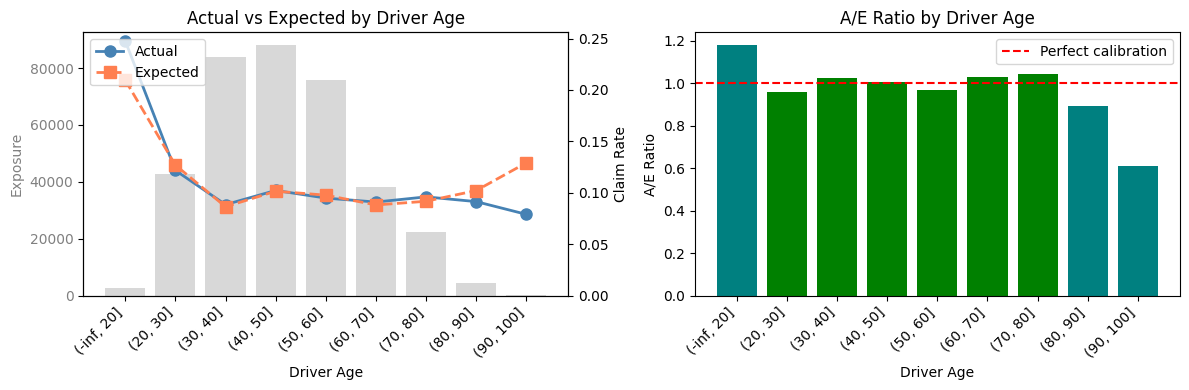

DrivAge_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 20]""",640,541.58401,2584.582839,1.181719,0.247622,0.209544
"""(20, 30]""",5218,5438.004766,42822.634243,0.959543,0.121851,0.126989
"""(30, 40]""",7435,7261.248248,83937.299011,1.023929,0.088578,0.086508
"""(40, 50]""",9021,8955.370397,88138.310203,1.007329,0.10235,0.101606
"""(50, 60]""",7190,7405.154967,75727.63601,0.970945,0.094946,0.097787
"""(60, 70]""",3491,3382.809151,38332.688531,1.031983,0.091071,0.088249
"""(70, 80]""",2138,2042.91437,22246.083144,1.046544,0.096107,0.091833
"""(80, 90]""",402,449.216693,4393.353277,0.894891,0.091502,0.102249
"""(90, 100]""",25,40.816536,315.938204,0.612497,0.079129,0.129192


In [27]:
plot_ae_chart(plot_data, "DrivAge", bins=[20,30,40,50,60,70,80,90,100], use_rate=True, title="Driver Age")

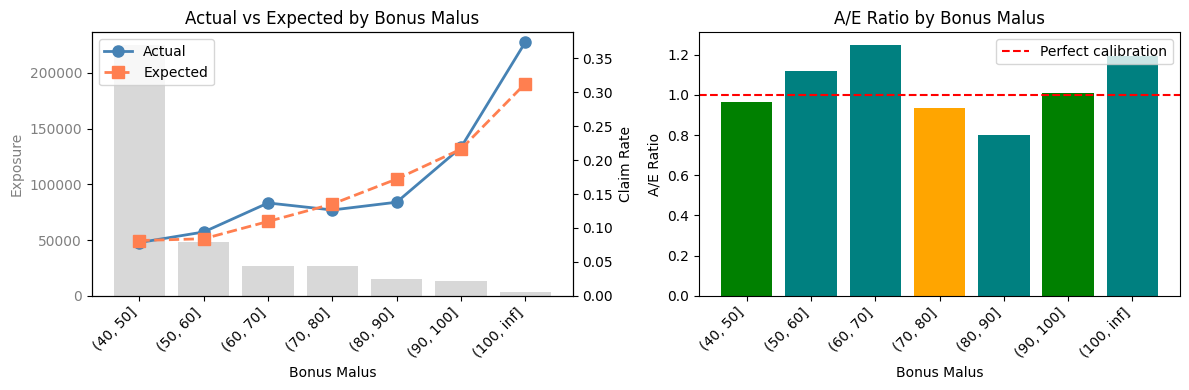

BonusMalus_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(40, 50]""",17688,18344.358618,225233.130902,0.96422,0.078532,0.081446
"""(50, 60]""",4515,4035.189598,47985.497013,1.118907,0.094091,0.084092
"""(60, 70]""",3627,2903.863764,26497.713499,1.249026,0.13688,0.109589
"""(70, 80]""",3361,3594.52591,26567.633294,0.935033,0.126507,0.135297
"""(80, 90]""",2104,2624.807748,15246.839478,0.801583,0.137996,0.172154
"""(90, 100]""",2930,2896.727146,13396.392272,1.011486,0.218716,0.216232
"""(100, inf]""",1335,1117.646356,3571.319003,1.194474,0.373811,0.312951


In [28]:
plot_ae_chart(plot_data, "BonusMalus", bins=[20,30,40,50,60,70,80,90,100], use_rate=True, title="Bonus Malus")

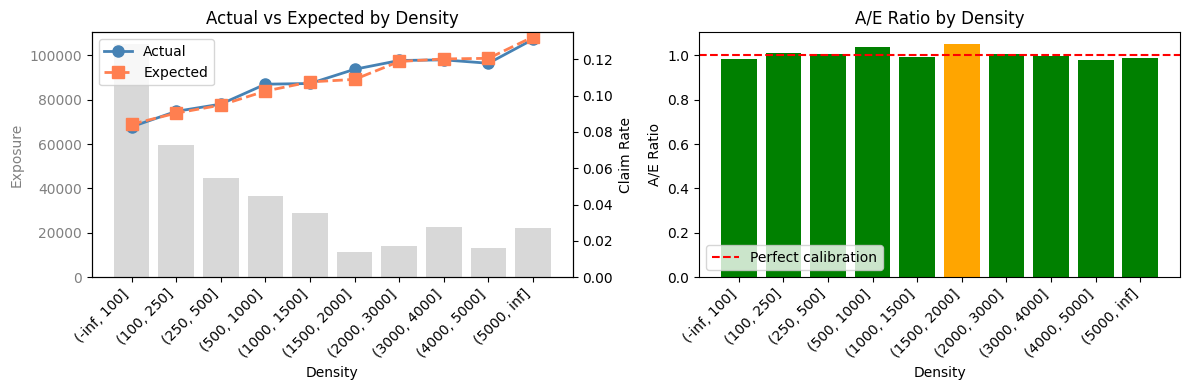

Density_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 100]""",8707,8854.514749,105067.386255,0.98334,0.082871,0.084275
"""(100, 250]""",5460,5401.954253,59766.263508,1.010745,0.091356,0.090385
"""(250, 500]""",4257,4231.959699,44644.931144,1.005917,0.095352,0.094791
"""(500, 1000]""",3912,3772.656059,36793.095132,1.036935,0.106324,0.102537
"""(1000, 1500]""",3088,3113.038096,28937.801585,0.991957,0.106712,0.107577
"""(1500, 2000]""",1299,1235.887041,11340.499495,1.051067,0.114545,0.10898
"""(2000, 3000]""",1678,1670.187211,14054.663173,1.004678,0.119391,0.118835
"""(3000, 4000]""",2706,2717.705867,22601.158855,0.995693,0.119728,0.120246
"""(4000, 5000]""",1535,1570.475385,13024.424481,0.977411,0.117855,0.120579


In [29]:
plot_ae_chart(plot_data, "Density", bins=[100, 250, 500, 1000, 1500, 2000,3000,4000,5000], use_rate=True, title="Density")

In [18]:
# Test s() smooth terms with AUTO-DF SELECTION via GCV
# - Tries df values [3, 4, 5, 6, 8, 10] and picks best via GCV
# - Uses 10k subsample for fast selection, then builds full basis
# - Final fit uses standard IRLS (works with elastic net too)

import time

formula_smooth = """
    ClaimCount ~
    s(VehPower) +
    s(VehAge) +
    s(DrivAge) +
    s(BonusMalus) +
    TE(VehBrand) +
    TE(VehGas) +
    TE(Area) +
    s(Density) +
    TE(Region)
"""

start = time.time()
model_smooth = rs.glm(
    formula=formula_smooth,
    data=data,
    family="poisson",
    offset="Exposure"
)
print(f"Design matrix built in {time.time() - start:.2f}s")
print(f"Auto-selected dfs: {model_smooth._smooth_selected_dfs}")

start = time.time()
result_smooth = model_smooth.fit()
print(f"Model fit in {time.time() - start:.2f}s")
print(result_smooth.summary())

Design matrix built in 2.84s
Auto-selected dfs: {'VehPower': 3, 'VehAge': 8, 'DrivAge': 10, 'BonusMalus': 3, 'Density': 4}
Model fit in 0.57s
                                 GLM Results                                  

Family:              Poisson         No. Observations:        678012
Link Function:       (default)       Df Residuals:            677984
Method:              IRLS            Df Model:                    27
Scale:               1.0000          Iterations:                   6

Log-Likelihood:         -139171.4556 Deviance:                209342.7651
AIC:                     278398.9112 Null Deviance:           214041.4441
BIC:                     278718.8650 Pearson chi2:             1520591.42
Converged:           True           

------------------------------------------------------------------------------
Variable                 Coef    Std.Err        z    P>|z|                 95% CI     
---------------------------------------------------------------------------